# Exercise c, d: 기존의 모델과 새로운 모델 비교 실험

이 파일은 기존의 모델($w \times t_u + b$)과 새로운 모델($w_2 \times t_u^2 + w_1 \times t_u + b$)의 성능 차이를 평가하기 위한 실험 코드를 저장한 파일이다.

**Exercise의 문항 c, d번을 답하기 위해 사용된다.**

## 1. 실험 준비

실험 진행을 위한 기본적인 함수와 데이터를 정의한다.

### 1-1. 패키지 Import

기본적인 PyTorch 패키지를 비롯하여, Type hinting을 위한 패키지와 그래프를 그리기 위한 matplotlib 등을 모두 Import 한다.

In [298]:
%matplotlib inline
import torch
from torch import Tensor
import torch.optim as optim
from typing import Callable, Dict, List
from dataclasses import dataclass
from matplotlib import pyplot as plt

### 1-2. 모델 정의

`original_model` 함수는 기존의 모델, `redefined_model` 함수는 새로운 모델을 나타낸다. 두 함수의 인자에 차이가 있음을 알 수 있다.

In [299]:
# t_u: Input Tensor
# w: Weight parameters, b: Bias 
def original_model(t_u: Tensor, w: Tensor, b: Tensor) -> Tensor:
    return w * t_u + b

# t_u: Input Tensor
# w: Weight parameters, b: Bias 
def redefined_model(t_u: Tensor, w1: Tensor, w2: Tensor, b: Tensor) -> Tensor:
    return (w2 * t_u ** 2) + (w1 * t_u) + b

### 1-3. Loss Function 정의

예측값과 정답의 오차를 제곱한 값으로, 기존의 Loss function을 그대로 이용한다.

In [300]:
def loss_fn(t_p: Tensor, t_c: Tensor) -> Tensor:
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

### 1-4. 학습을 위한 함수 정의

`training_loop` 는 모델과 Optimizer를 인자로 받고, 입력받은 모델에 맞게 주어진 Epoch 수 만큼 파라미터를 최적화시킨다. 학습 결과는 `TrainingResult` 라는 클래스로 반환하는데, 이 클래스에는 최적화된 파라미터 Tensor와 Training Loss, Validation Loss의 리스트를 담고 있다.

기존의 로직에서 크게 바뀐 사항은 없으며, 단지 모델과 Optimizer를 파라미터로 받고, 반환 객체에 Loss 리스트를 추가한 것이 변동사항의 전부이다.

In [301]:
@dataclass
class TrainingResult:
    params: Tensor
    train_loss_list: List[float]
    val_loss_list: List[float]

In [302]:
def training_loop(n_epochs: int, optimizer: optim.Optimizer, params: Tensor, model: Callable,
                  train_t_u: Tensor, val_t_u: Tensor,
                  train_t_c: Tensor, val_t_c: Tensor, print_log: bool=False) -> TrainingResult:
    train_loss_result = [0 for _ in range(n_epochs)]
    val_loss_result = [0 for _ in range(n_epochs)]

    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        train_loss_result[epoch-1] = float(train_loss.item())
                             
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)
        val_loss_result[epoch-1] = float(val_loss.item())
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if print_log and (epoch <= 3 or epoch % 500 == 0):
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
            
    return TrainingResult(params, train_loss_result, val_loss_result)

### 1-5. 데이터셋 준비

데이터를 랜덤 셔플한 뒤 입력 데이터에 정규화를 시행한다.

In [303]:
def prepare_dataset() -> Dict[str, Tensor]:
    t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0,
                    8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
    t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                        33.9, 21.8, 48.4, 60.4, 68.4])

    n_samples = t_u.shape[0]
    n_val = int(0.2 * n_samples)

    shuffled_indices = torch.randperm(n_samples)

    train_indices = shuffled_indices[:-n_val]
    val_indices = shuffled_indices[-n_val:]

    train_indices, val_indices

    train_t_u = t_u[train_indices]
    train_t_c = t_c[train_indices]

    val_t_u = t_u[val_indices]
    val_t_c = t_c[val_indices]

    train_t_un = 0.1 * train_t_u
    val_t_un = 0.1 * val_t_u

    return {
        "train_t_u": train_t_un,
        "val_t_u": val_t_un,
        "train_t_c":  train_t_c,
        "val_t_c": val_t_c
    }

dataset = prepare_dataset()

## 2. 비교 실험 진행

두 모델에 대하여 같은 조건으로 비교 실험을 진행한다.

* Epoch: $1,000$
* Learning Rate: $10^{-1}$
* Optimizer: Adam

In [304]:
N_EPOCHS = 1000
LEARNING_RATE = 1e-1

### 2-1. 기존의 모델

`experiment_original` 함수는 기존의 모델에 맞게 파라미터 최적화를 시행한다.

In [305]:
def experiment_original(print_log: bool=False) -> TrainingResult:
    params = torch.tensor([1.0, 0.0], requires_grad=True)
    optimizer = optim.Adam([params], lr=LEARNING_RATE)

    return training_loop(
        n_epochs=N_EPOCHS,
        optimizer=optimizer,
        params=params,
        model=original_model,
        print_log=print_log,
        **dataset
    )

original_result = experiment_original(True)

Epoch 1, Training loss 51.4150, Validation loss 210.6365
Epoch 2, Training loss 45.8208, Validation loss 189.5128
Epoch 3, Training loss 40.9619, Validation loss 169.7757
Epoch 500, Training loss 2.9175, Validation loss 3.6702
Epoch 1000, Training loss 2.9111, Validation loss 3.3966


### 2-2. 새로운 모델

`experiment_redefined` 함수는 새로운 모델에 맞게 파라미터 최적화를 시행한다.

In [306]:
def experiment_redefined(print_log: bool=False) -> TrainingResult:
    params = torch.tensor([1.0, 0.0, 0.0], requires_grad=True)
    optimizer = optim.Adam([params], lr=LEARNING_RATE)

    return training_loop(
        n_epochs=N_EPOCHS,
        optimizer=optimizer,
        params=params,
        model=redefined_model,
        print_log=print_log,
        **dataset
    )

redefined_result = experiment_redefined(True)

Epoch 1, Training loss 51.4150, Validation loss 210.6365
Epoch 2, Training loss 23.1888, Validation loss 75.3991
Epoch 3, Training loss 17.3617, Validation loss 15.7157
Epoch 500, Training loss 2.1791, Validation loss 13.3067
Epoch 1000, Training loss 2.1270, Validation loss 10.2992


### 2-3. 두 모델의 Loss Graph 비교

두 모델의 파라미터를 최적화하는 과정에서 나타난 Loss 값을 $x$ 축을 Epoch으로 하여 그래프를 그린다.

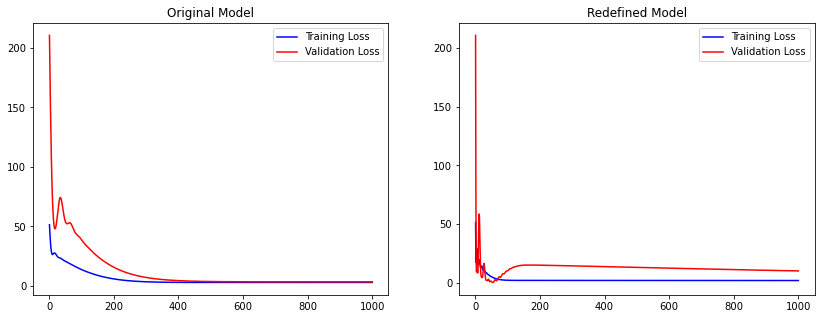

In [307]:
def plot_loss(cell: plt.Axes, loss_data: TrainingResult):
    cell.plot(range(1, N_EPOCHS+1), loss_data.train_loss_list, color="blue", label="Training Loss")
    cell.plot(range(1, N_EPOCHS+1), loss_data.val_loss_list, color="red", label="Validation Loss")
    cell.legend(loc="upper right")

fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(121)
plot_loss(ax1, original_result)
ax1.set_title("Original Model")

ax2 = fig.add_subplot(122)
plot_loss(ax2, redefined_result)
ax2.set_title("Redefined Model")

plt.show()

### 2-4. 반복 실험

20회 같은 실험을 반복하면서 Validation Loss가 Training Loss보다 평균적으로 몇 퍼센트나 높았는지 측정한다.

In [308]:
EXPERIMENT_COUNT = 20

def experiment_repeatedly(experiment: Callable[[], TrainingResult]):
    ratio_sum = 0.0
    for _ in range(EXPERIMENT_COUNT):
        result = experiment()
        ratio_sum += result.val_loss_list[-1] / result.train_loss_list[-1] * 100
    return ratio_sum / EXPERIMENT_COUNT

print(f"After {EXPERIMENT_COUNT} experiments...")
print(f"\tOriginal: Validation loss is {experiment_repeatedly(experiment_original)}% greater than training loss.")
print(f"\tRedefined: Validation loss is {experiment_repeatedly(experiment_redefined)}% greater than training loss.")

After 20 experiments...
	Original: Validation loss is 116.675915735631% greater than training loss.
	Redefined: Validation loss is 484.2144294637739% greater than training loss.
